<a href="https://colab.research.google.com/github/giriprakash16-tech/SPECIFIC-AREA-OF-HEALTHCARE-HEART-ATTACK-PREDICTION-MODEL-USING-MACHINE-LEARNING/blob/main/Code_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages (only run once in a new environment)
# !pip install xgboost lightgbm shap openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import shap

# Display settings
pd.set_option('display.max_columns', None)

In [ ]:
# Load dataset
file_path = '/content/Medicaldataset_Expanded.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

In [ ]:
# Display the first few rows
print("First 5 rows:")
display(df.head())

First 5 rows:


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [ ]:
# Get basic info about the dataset
print("\n Dataset Info:")
df.info()


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  int64  
 1   Gender                    100000 non-null  int64  
 2   Heart rate                100000 non-null  int64  
 3   Systolic blood pressure   100000 non-null  int64  
 4   Diastolic blood pressure  100000 non-null  int64  
 5   Blood sugar               100000 non-null  float64
 6   CK-MB                     100000 non-null  float64
 7   Troponin                  100000 non-null  float64
 8   Result                    100000 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 6.9+ MB


In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Make a copy of the dataset to keep original intact
df_processed = df.copy()

In [ ]:
# Convert 'Result' to numeric: 'positive' -> 1, 'negative' -> 0
df_processed['Result'] = df_processed['Result'].map({'positive': 1, 'negative': 0})

In [ ]:
# List of numerical columns to scale (excluding target column)
numeric_cols = df_processed.drop(columns=['Result']).select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

print("\n Normalized Numerical Features Sample:")
display(df_processed.head())


 Normalized Numerical Features Sample:


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.571727,0.718028,-0.240637,1.261115,0.767856,0.188450,-0.292901,-0.304172,0
1,-2.575439,0.718028,0.304336,-1.114611,-1.872131,2.023557,-0.188121,0.601926,1
2,-0.086982,0.718028,-0.279563,1.261115,0.339750,1.672728,-0.288879,-0.311953,0
3,0.571727,0.718028,-0.162784,-0.271611,-1.229972,1.672728,-0.037406,-0.209066,1
4,-0.086982,0.718028,-0.279563,-0.578157,-0.516462,2.077531,-0.308142,-0.311953,0


In [ ]:
# Check for other object-type categorical features (besides 'Result')
categorical_cols = df_processed.select_dtypes(include=['object']).columns

if len(categorical_cols) > 0:
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

In [ ]:
# View basic info of the processed dataset
print("Dataset Info:")
df_processed.info()

# View descriptive statistics
print("\n Descriptive Statistics:")
display(df_processed.describe())

# Check column names and data types
print("\n Column Names and Data Types:")
for col in df_processed.columns:
    print(f"{col}: {df_processed[col].dtype}")

# Display first few rows
print("\n First 5 Rows of Processed Dataset:")
display(df_processed.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Gender                    100000 non-null  float64
 2   Heart rate                100000 non-null  float64
 3   Systolic blood pressure   100000 non-null  float64
 4   Diastolic blood pressure  100000 non-null  float64
 5   Blood sugar               100000 non-null  float64
 6   CK-MB                     100000 non-null  float64
 7   Troponin                  100000 non-null  float64
 8   Result                    100000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 6.9 MB

 Descriptive Statistics:


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,8.384404e-18,3.954170e-17,-6.252776e-18,2.131628e-18,2.426503e-17,1.879386e-17,3.907985e-19,-6.892265e-18,0.616310
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.486286
min,-3.087768e+00,-1.392702e+00,-1.174875e+00,-3.298746e+00,-2.442939e+00,-1.526669e+00,-3.589398e-01,-3.489501e-01,0.000000
25%,-6.725012e-01,-1.392702e+00,-2.795634e-01,-6.547930e-01,-7.305150e-01,-6.508450e-01,-2.952368e-01,-3.099344e-01,0.000000
50%,1.325879e-01,7.180284e-01,-8.493044e-02,-1.183387e-01,-1.700508e-02,-4.062314e-01,-2.699241e-01,-2.979657e-01,1.000000
75%,6.449173e-01,7.180284e-01,1.291658e-01,6.097063e-01,6.251538e-01,3.040625e-01,-2.052774e-01,-2.382199e-01,1.000000
max,3.426134e+00,7.180284e-01,2.013744e+01,3.713477e+00,5.833776e+00,5.349895e+00,6.053094e+00,8.617137e+00,1.000000



 Column Names and Data Types:
Age: float64
Gender: float64
Heart rate: float64
Systolic blood pressure: float64
Diastolic blood pressure: float64
Blood sugar: float64
CK-MB: float64
Troponin: float64
Result: int64

 First 5 Rows of Processed Dataset:


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.571727,0.718028,-0.240637,1.261115,0.767856,0.188450,-0.292901,-0.304172,0
1,-2.575439,0.718028,0.304336,-1.114611,-1.872131,2.023557,-0.188121,0.601926,1
2,-0.086982,0.718028,-0.279563,1.261115,0.339750,1.672728,-0.288879,-0.311953,0
3,0.571727,0.718028,-0.162784,-0.271611,-1.229972,1.672728,-0.037406,-0.209066,1
4,-0.086982,0.718028,-0.279563,-0.578157,-0.516462,2.077531,-0.308142,-0.311953,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent visual style
sns.set(style="whitegrid")

/tmp/ipython-input-11-3923371481.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Result', data=df_processed, palette='Set2')


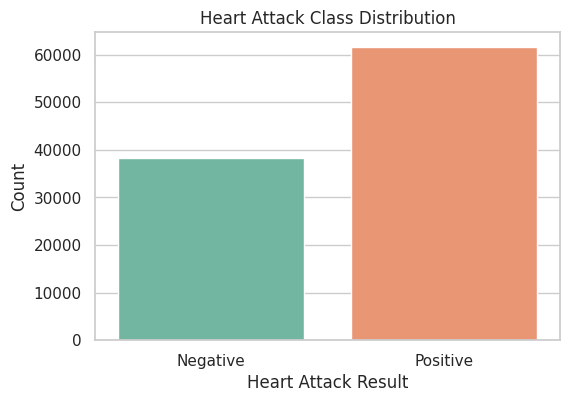

In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Result', data=df_processed, palette='Set2')
plt.title("Heart Attack Class Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Heart Attack Result")
plt.ylabel("Count")
plt.show()

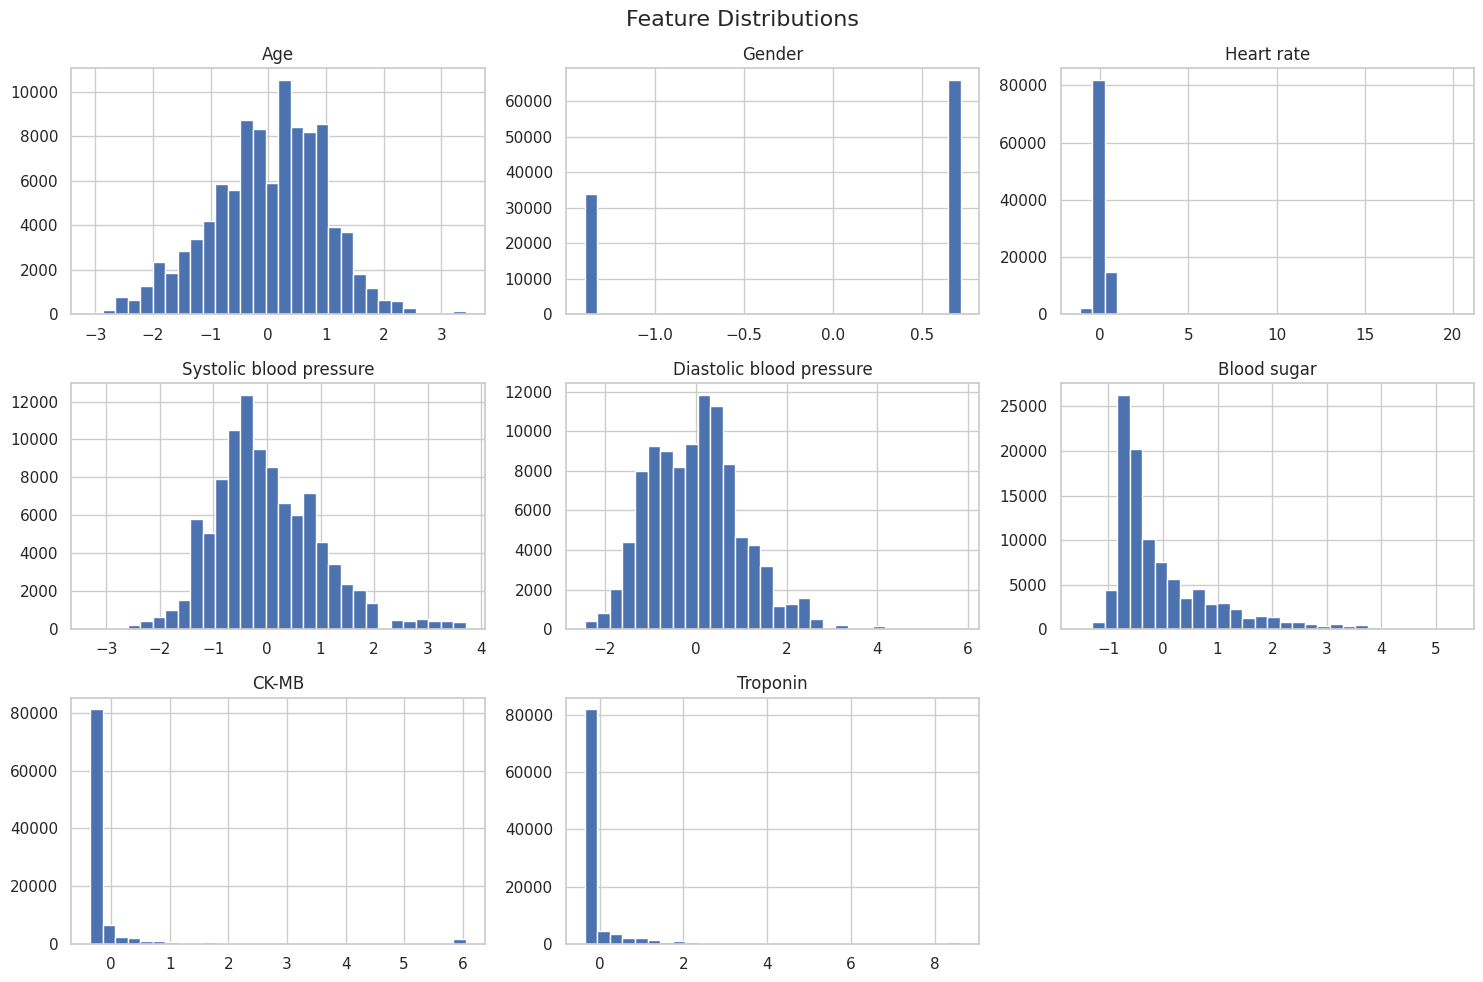

In [ ]:
# Plot histogram for each numerical feature
df_processed.drop(columns='Result').hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

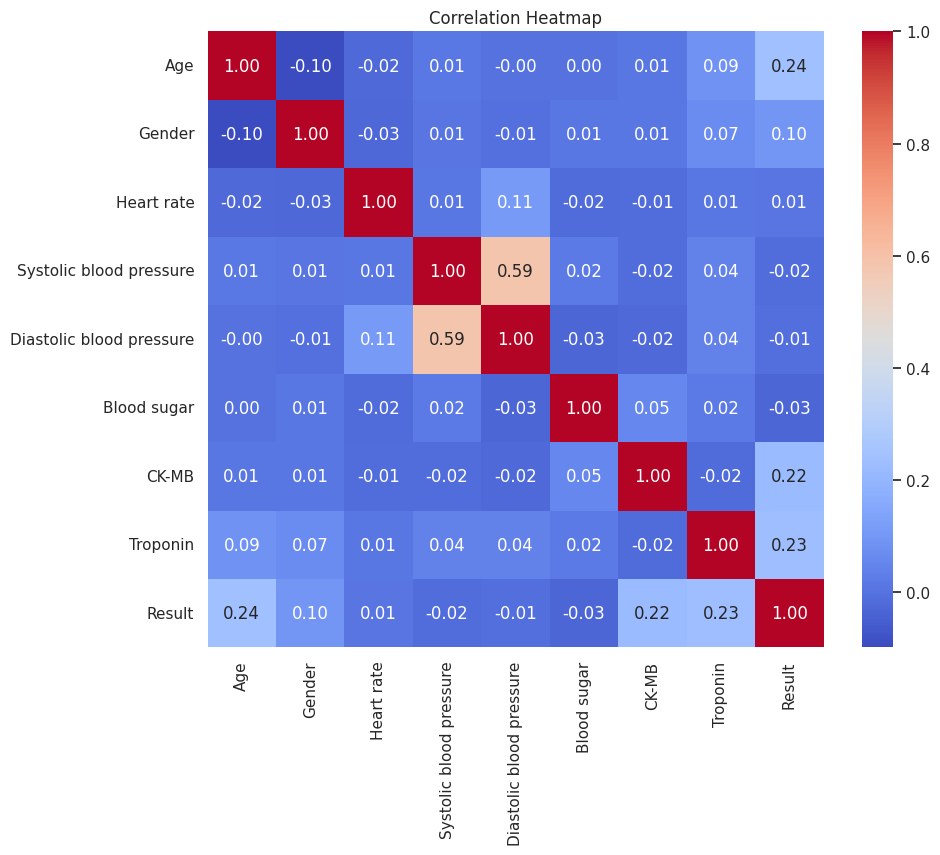

In [ ]:
# Compute correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df_processed.corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

/tmp/ipython-input-14-1794587287.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result', y='Troponin', data=df_processed, palette='Set1')
/tmp/ipython-input-14-1794587287.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result', y='CK-MB', data=df_processed, palette='Set1')


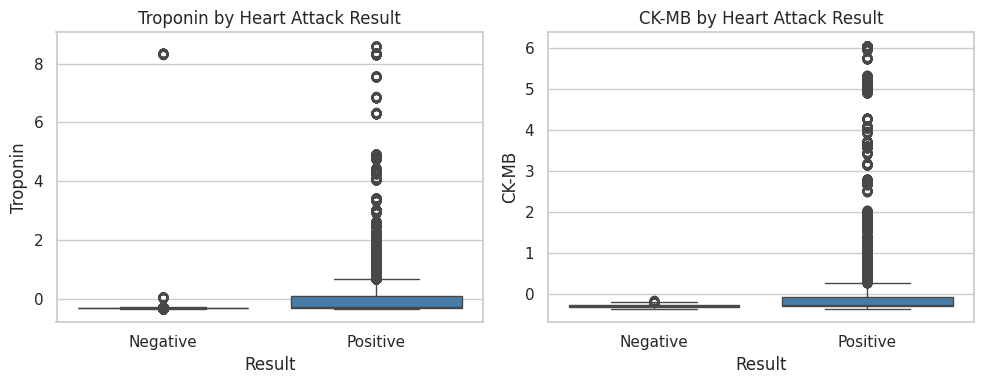

In [ ]:
# Boxplot: Troponin vs. Result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='Result', y='Troponin', data=df_processed, palette='Set1')
plt.title("Troponin by Heart Attack Result")
plt.xticks([0, 1], ['Negative', 'Positive'])

# Boxplot: CK-MB vs. Result
plt.subplot(1, 2, 2)
sns.boxplot(x='Result', y='CK-MB', data=df_processed, palette='Set1')
plt.title("CK-MB by Heart Attack Result")
plt.xticks([0, 1], ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

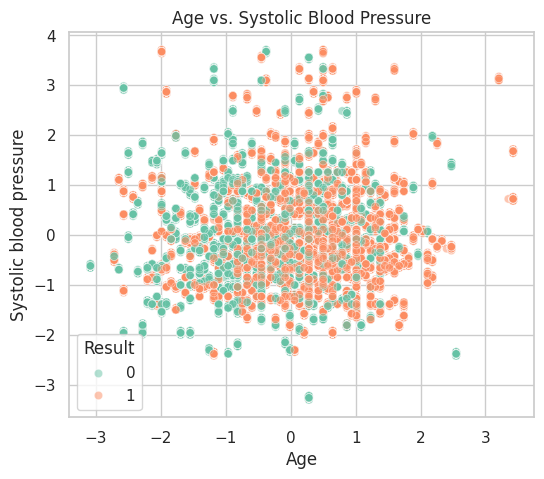

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Age', y='Systolic blood pressure', hue='Result', data=df_processed, palette='Set2', alpha=0.5)
plt.title("Age vs. Systolic Blood Pressure")
plt.show()

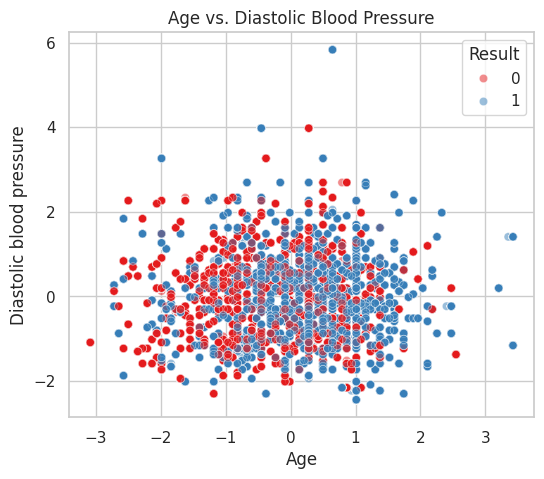

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Age', y='Diastolic blood pressure', hue='Result', data=df_processed, palette='Set1', alpha=0.5)
plt.title("Age vs. Diastolic Blood Pressure")
plt.show()

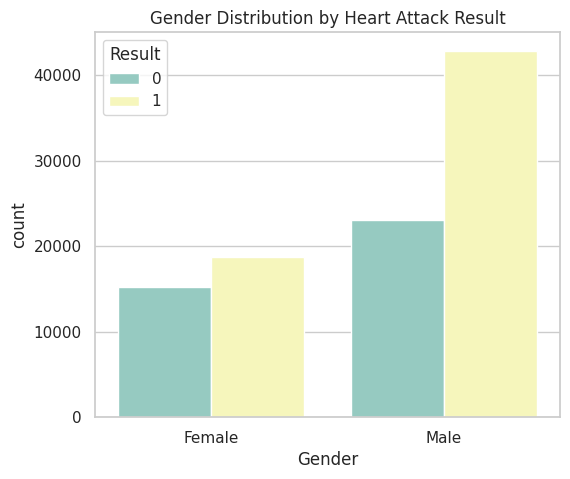

In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Gender', hue='Result', data=df_processed, palette='Set3')
plt.title("Gender Distribution by Heart Attack Result")
plt.xticks([0, 1], ['Female', 'Male'])  # Assuming 0: Female, 1: Male
plt.show()

In [ ]:
# Create Pulse Pressure
df['Pulse Pressure'] = df['Systolic blood pressure'] - df['Diastolic blood pressure']

In [ ]:
# Define bins and labels
bins = [0, 35, 60, 100]
labels = ['young', 'middle-aged', 'senior']

# Create age group column
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

In [ ]:
import numpy as np

# Apply log1p (log(1 + x)) to handle zeros and skewness
df['CK-MB_log'] = np.log1p(df['CK-MB'])
df['Blood sugar_log'] = np.log1p(df['Blood sugar'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Convert categorical age group to numeric (Label Encoding)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Age Group Encoded'] = le.fit_transform(df['Age Group'])

In [ ]:
# View sample of new features
df[['Age', 'Age Group', 'Pulse Pressure', 'CK-MB', 'CK-MB_log', 'Blood sugar', 'Blood sugar_log']].head()

,Age,Age Group,Pulse Pressure,CK-MB,CK-MB_log,Blood sugar,Blood sugar_log
0,64,senior,77,1.80,1.029619,160.0,5.081404
1,21,young,52,6.75,2.047693,296.0,5.693732
2,55,middle-aged,83,1.99,1.095273,270.0,5.602119
3,64,senior,65,13.87,2.699346,270.0,5.602119
4,55,middle-aged,47,1.08,0.732368,300.0,5.707110


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Age                       100000 non-null  int64   
 1   Gender                    100000 non-null  int64   
 2   Heart rate                100000 non-null  int64   
 3   Systolic blood pressure   100000 non-null  int64   
 4   Diastolic blood pressure  100000 non-null  int64   
 5   Blood sugar               100000 non-null  float64 
 6   CK-MB                     100000 non-null  float64 
 7   Troponin                  100000 non-null  float64 
 8   Result                    100000 non-null  object  
 9   Pulse Pressure            100000 non-null  int64   
 10  Age Group                 99846 non-null   category
 11  CK-MB_log                 99997 non-null   float64 
 12  Blood sugar_log           100000 non-null  float64 
 13  Age Group Encoded         1000

Train class distribution (before SMOTE):
 Result
positive    0.6163
negative    0.3837
Name: proportion, dtype: float64
Train class distribution (after SMOTE):
 Result
positive    0.5
negative    0.5
Name: proportion, dtype: float64


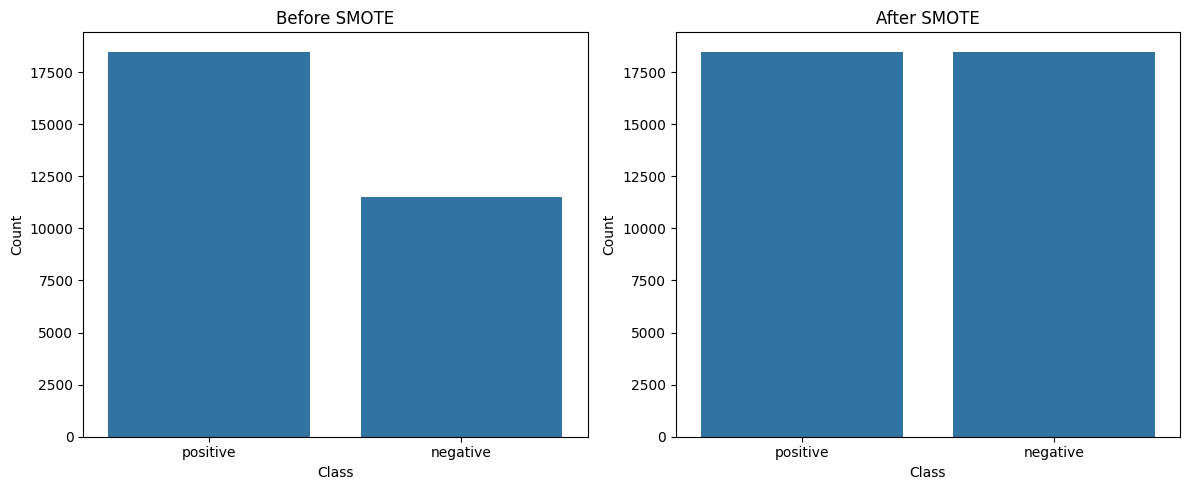

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Separate features and target
features = df.drop(columns=['Result', 'Age Group'])  # drop categorical col
target = df['Result']

# Step 2: Train-test split with stratification
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

# Step 2.1: Downsample training data to 30,000
train_sample_size = 30000
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_full, y_train_full, train_size=train_sample_size, stratify=y_train_full, random_state=42
)

# Step 3: Impute missing values in training and test sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_sampled)
X_test_imputed = imputer.transform(X_test)

# Step 4: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train_sampled)

# Step 5: Visualize class distribution
print("Train class distribution (before SMOTE):\n", y_train_sampled.value_counts(normalize=True))
print("Train class distribution (after SMOTE):\n", y_train_balanced.value_counts(normalize=True))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train_sampled, ax=axes[0])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

sns.countplot(x=y_train_balanced, ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Ensure target labels are numeric ---
label_map = {'negative': 0, 'positive': 1}
y_train_balanced = y_train_balanced.map(label_map) if y_train_balanced.dtype == 'object' else y_train_balanced
y_test = y_test.map(label_map) if y_test.dtype == 'object' else y_test

# --- Step 2: Define models (simplified for speed) ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {
    "Logistic Regression": log_reg,
    "Gradient Boosting": gbc,
    "Random Forest": rf,
    "XGBoost": xgb
}

# --- Step 3: Evaluation Function ---
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f" Accuracy: {acc:.4f}")
    print(f" ROC-AUC:  {roc_auc:.4f}")
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()


 Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Accuracy: 0.8013
 ROC-AUC:  0.9048
 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78      7674
           1       0.94      0.72      0.82     12326

    accuracy                           0.80     20000
   macro avg       0.81      0.82      0.80     20000
weighted avg       0.84      0.80      0.80     20000



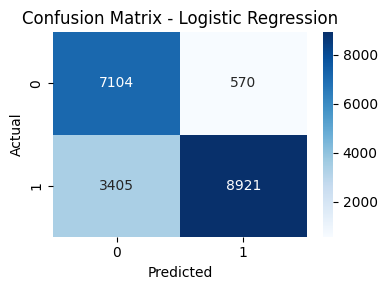

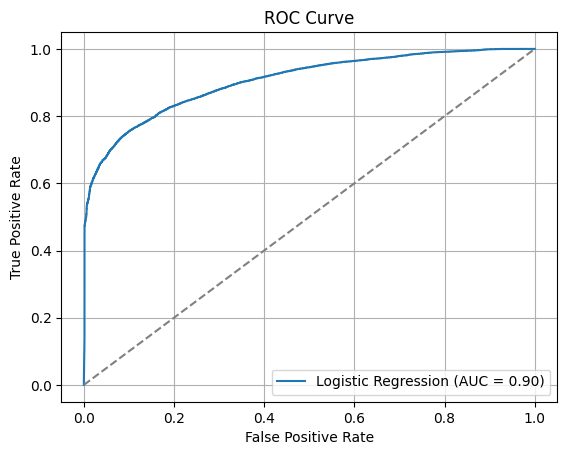

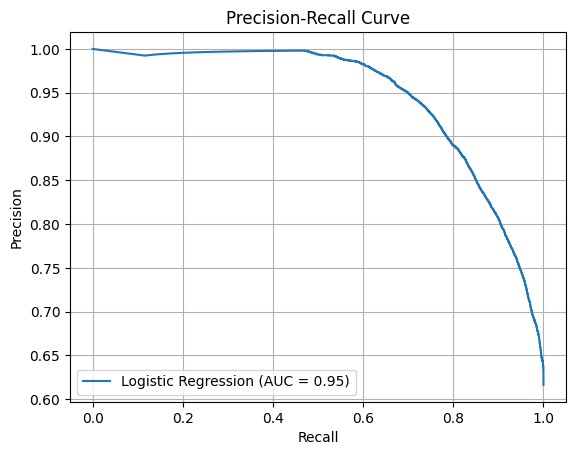

In [ ]:
# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)

train_and_evaluate(log_reg, X_train_balanced, y_train_balanced, X_test_imputed, y_test, "Logistic Regression")


 Random Forest
 Accuracy: 0.9307
 ROC-AUC:  0.9908
 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7674
           1       0.98      0.91      0.94     12326

    accuracy                           0.93     20000
   macro avg       0.92      0.94      0.93     20000
weighted avg       0.94      0.93      0.93     20000



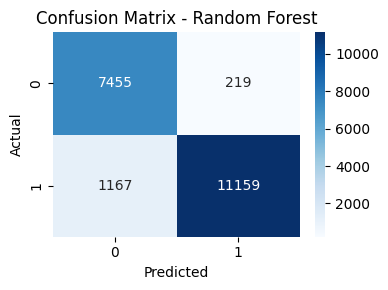

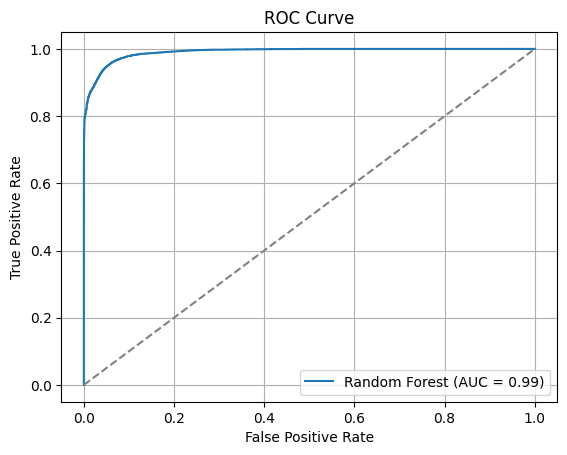

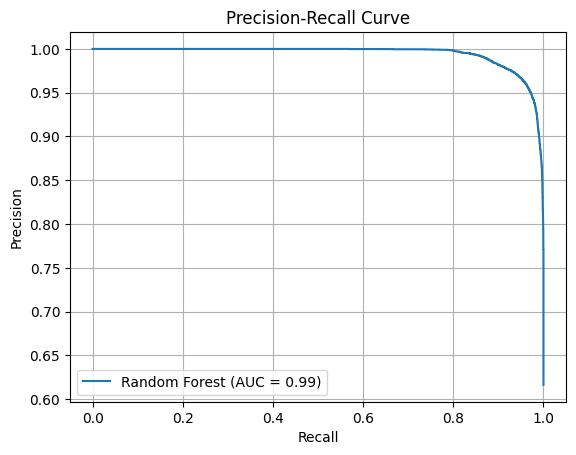

In [ ]:
# --- Random Forest (Lightweight) ---
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

train_and_evaluate(rf, X_train_balanced, y_train_balanced, X_test_imputed, y_test, "Random Forest")


 XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:57:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Accuracy: 0.9522
 ROC-AUC:  0.9934
 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7674
           1       0.99      0.94      0.96     12326

    accuracy                           0.95     20000
   macro avg       0.95      0.96      0.95     20000
weighted avg       0.95      0.95      0.95     20000



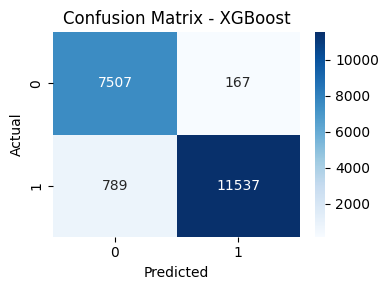

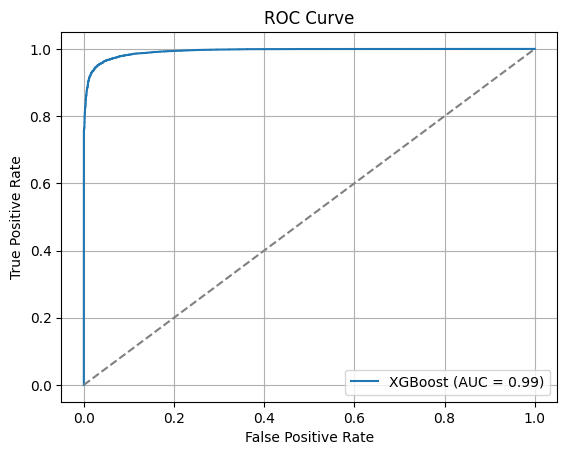

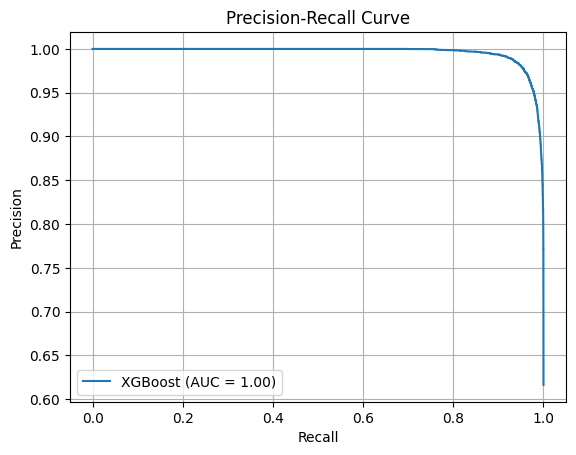

In [ ]:
# --- XGBoost (Reduced Complexity) ---
xgb = XGBClassifier(n_estimators=50, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=42)

train_and_evaluate(xgb, X_train_balanced, y_train_balanced, X_test_imputed, y_test, "XGBoost")


 Gradient Boosting Classifier
 Accuracy: 0.9040
 ROC-AUC:  0.9706
 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      7674
           1       0.96      0.88      0.92     12326

    accuracy                           0.90     20000
   macro avg       0.90      0.91      0.90     20000
weighted avg       0.91      0.90      0.90     20000



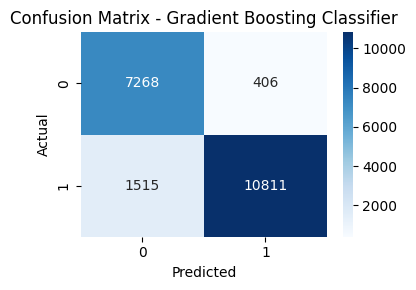

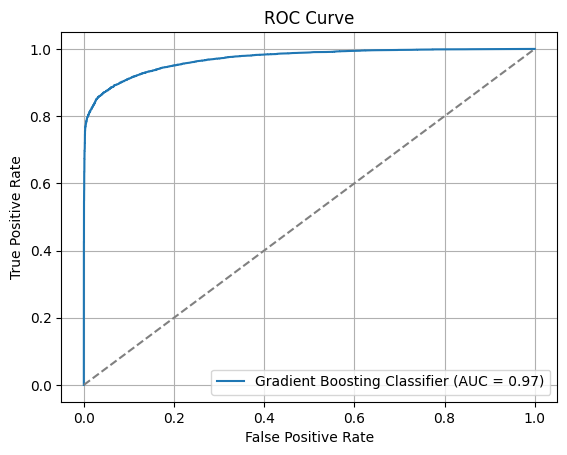

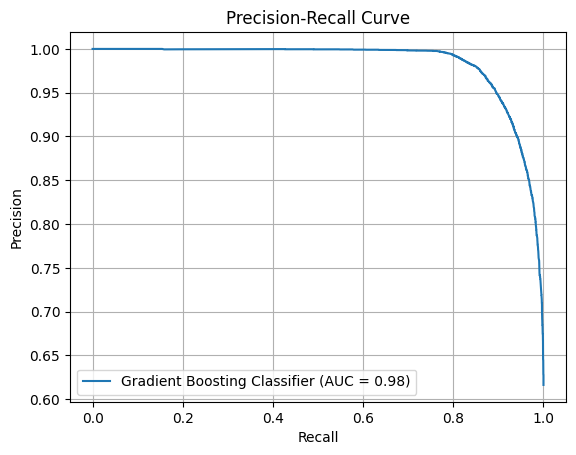

In [ ]:
# --- Gradient Boosting Classifier ---
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

train_and_evaluate(gbc, X_train_balanced, y_train_balanced, X_test_imputed, y_test, "Gradient Boosting Classifier")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# --- 3-Fold CV ---
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- XGBoost tuning ---
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=cv_strategy, n_iter=5, scoring='f1', n_jobs=-1, random_state=42)
xgb_search.fit(X_train_balanced, y_train_balanced)
best_xgb = xgb_search.best_estimator_

print("Best XGBoost Parameters:", xgb_search.best_params_)

Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}



--- XGBoost Evaluation ---
Accuracy     : 0.9514
Precision    : 0.9863
Recall       : 0.9340
F1-score     : 0.9595
ROC-AUC Score: 0.9931

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7674
           1       0.99      0.93      0.96     12326

    accuracy                           0.95     20000
   macro avg       0.94      0.96      0.95     20000
weighted avg       0.95      0.95      0.95     20000



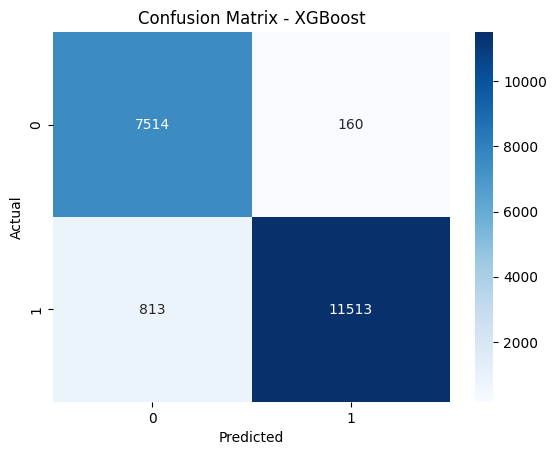

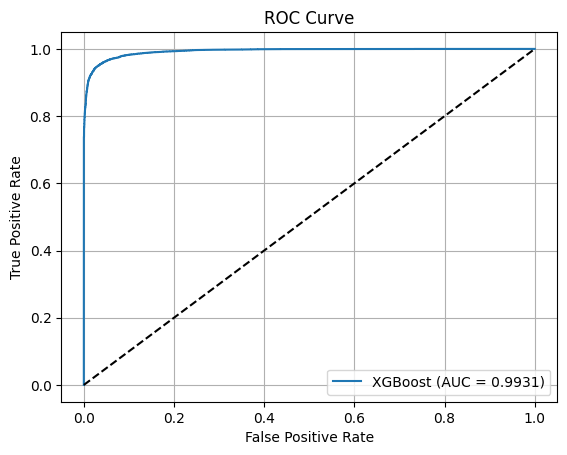

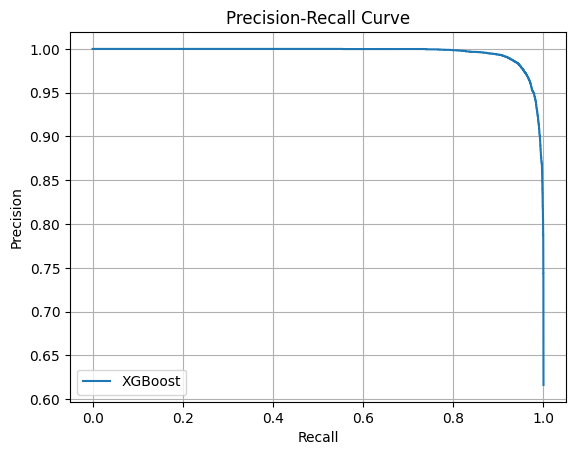

In [ ]:
from sklearn.metrics import classification_report

# Step 1: Predict on test data
y_pred = best_xgb.predict(X_test_imputed)
y_proba = best_xgb.predict_proba(X_test_imputed)[:, 1]

# Step 2: Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n--- XGBoost Evaluation ---")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 4: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recalls, precisions, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

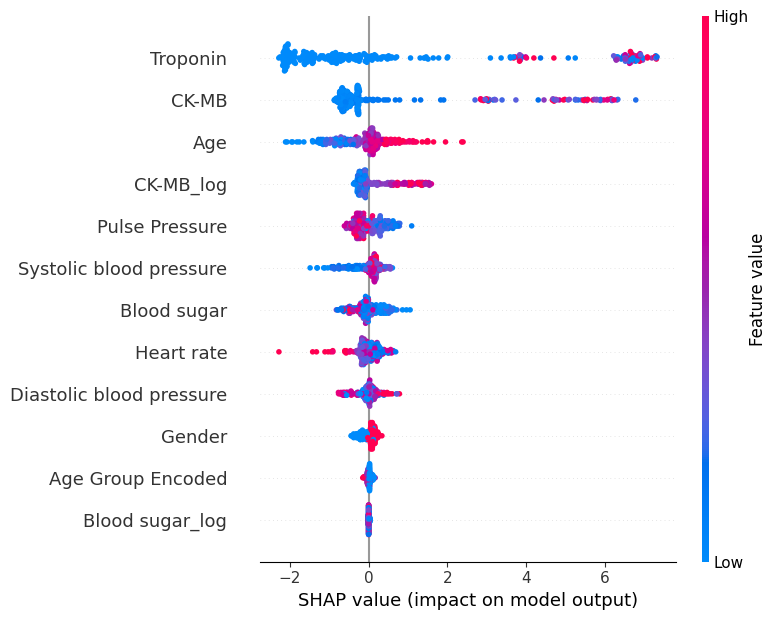

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Take a small sample from X_train_balanced for fast SHAP calculation
sample_size = 300
X_sample = X_train_balanced[:sample_size]

# Get column names from the original features DataFrame
feature_names = features.columns

# Convert to DataFrame for SHAP plotting
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# Step 2: Use SHAP TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_sample_df)

# Step 3: Plot feature importance (global explanation)
shap.summary_plot(shap_values, X_sample_df, max_display=15)

In [ ]:
# Visualize SHAP values for a single row (local explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample_df.iloc[0])

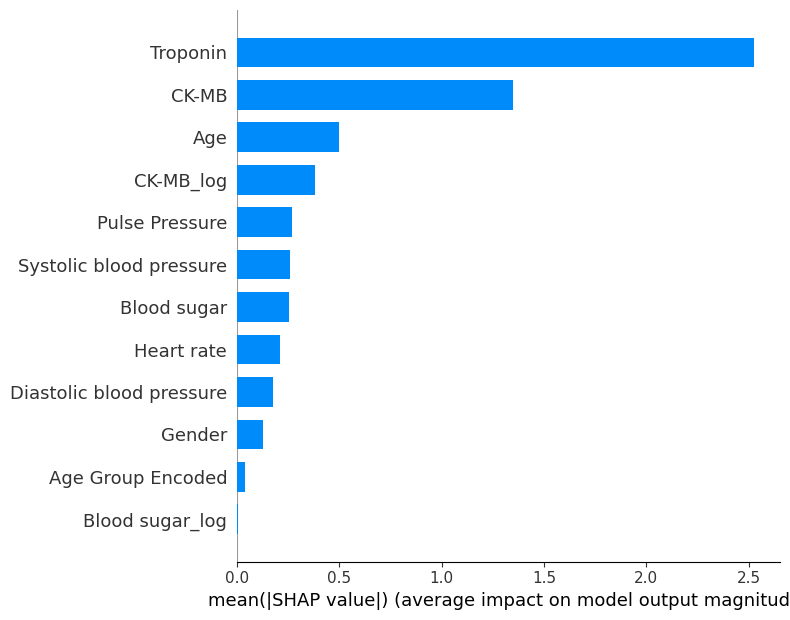

In [ ]:
shap.summary_plot(shap_values, X_sample_df, plot_type='bar', max_display=15)

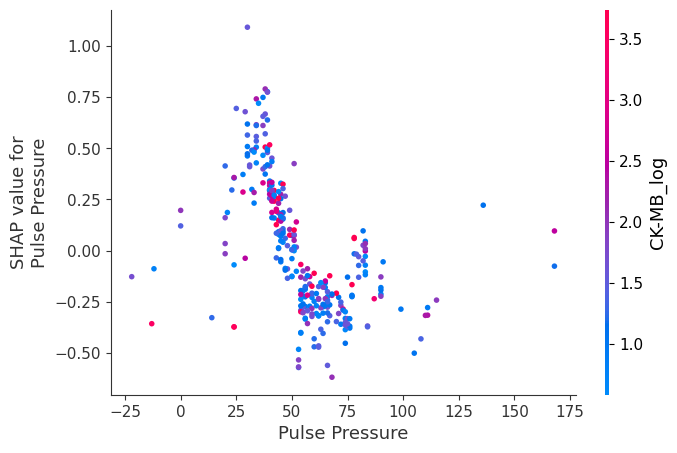

In [ ]:
shap.dependence_plot('Pulse Pressure', shap_values, X_sample_df)

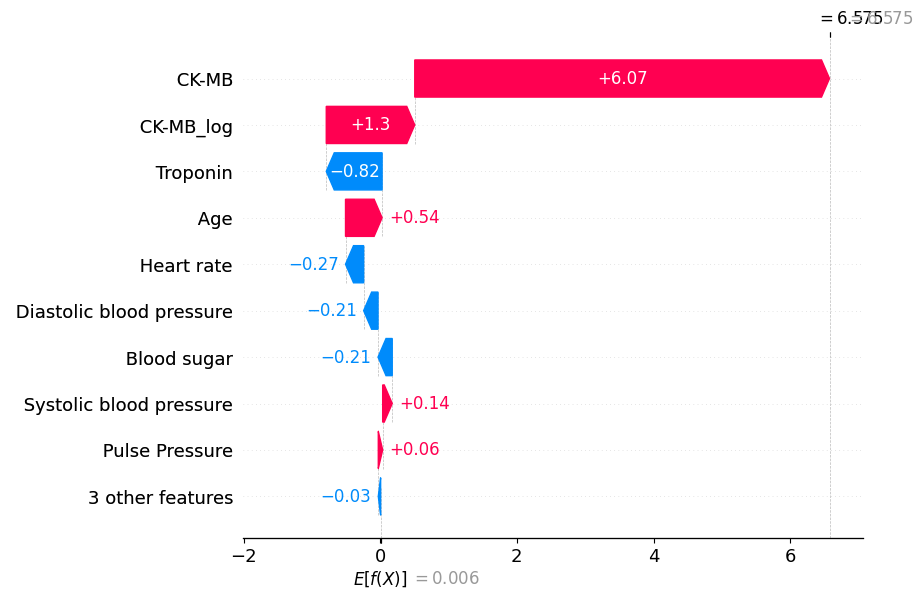

In [ ]:
# Choose a specific index
i = 0
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[i], X_sample_df.iloc[i])